# Text classification with Reuters-21578 datasets
Downloaded the from reuters21578 data set first. https://archive.ics.uci.edu/ml/machine-learning-databases/reuters21578-mld/



In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!pip install xml.sax.saxutils

ERROR: Could not find a version that satisfies the requirement xml.sax.saxutils (from versions: none)
ERROR: No matching distribution found for xml.sax.saxutils


In [ ]:
import re
import xml.sax.saxutils as saxutils

from bs4 import BeautifulSoup

from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from pandas import DataFrame

from random import random
import numpy as np
# Set Numpy random seed
np.random.seed(1)

In [ ]:

# import tarfile
# import tarfile
# import tarfile
# import tarfile
# import tarfile
import tarfile
my_tar = tarfile.open('reuters21578.tar.gz')
my_tar.extractall('./my_folder')# specify which folder to extract to
my_tar

### General constants (modify them according to you environment)

In [ ]:

# TODO: download the dataset and change the data_folder to match with yours
# Downloaded from https://archive.ics.uci.edu/ml/machine-learning-databases/reuters21578-mld/
data_folder = './my_folder/'
sgml_number_of_files = 22
sgml_file_name_template = 'reut2-{}.sgm'

# Category files
category_files = {
    'to_': ('Topics', 'all-topics-strings.lc.txt'),
    'pl_': ('Places', 'all-places-strings.lc.txt'),
    'pe_': ('People', 'all-people-strings.lc.txt'),
    'or_': ('Organizations', 'all-orgs-strings.lc.txt'),
    'ex_': ('Exchanges', 'all-exchanges-strings.lc.txt')
}

## Prepare documents and categories

In [ ]:
# Read all categories
category_data = []

for category_prefix in category_files.keys():
    with open(data_folder+category_files[category_prefix][1], 'r') as file:
        for category in file.readlines():
            category_data.append([category_prefix + category.strip().lower(), 
                                  category_files[category_prefix][0], 
                                  0])

# Create category dataframe
news_categories = DataFrame(data=category_data, columns=['Name', 'Type', 'Newslines'])

In [ ]:
news_categories.shape

(672, 3)

In [ ]:
def update_frequencies(categories):
    for category in categories:
        idx = news_categories[news_categories.Name == category].index[0]
        f = news_categories._get_value(idx, 'Newslines')
        news_categories._set_value(idx, 'Newslines', f+1)
    
def to_category_vector(categories, target_categories):
    vector = zeros(len(target_categories)).astype(float32)
    
    for i in range(len(target_categories)):
        if target_categories[i] in categories:
            vector[i] = 1.0
    
    return vector

In [ ]:
# Those are the top 20 categories we will use for the classification
selected_categories = ['pl_usa', 'to_earn', 'to_acq', 'pl_uk', 'pl_japan', 'pl_canada', 'to_money-fx',
 'to_crude', 'to_grain', 'pl_west-germany', 'to_trade', 'to_interest',
 'pl_france', 'or_ec', 'pl_brazil', 'to_wheat', 'to_ship', 'pl_australia',
 'to_corn', 'pl_china']

# Parse SGML files
document_X = []
document_Y = []

def strip_tags(text):
    return re.sub('<[^<]+?>', '', text).strip()

def unescape(text):
    return saxutils.unescape(text)

# Iterate all files
for i in range(sgml_number_of_files):
    file_name = sgml_file_name_template.format(str(i).zfill(3))
    print('Reading file: %s' % file_name)
    
    with open(data_folder+ file_name, 'rb') as file:
        content = BeautifulSoup(file.read().lower(), "lxml")
        
        for newsline in content('reuters'):
            document_categories = []
            
            # News-line Id
            document_id = newsline['newid']
            
            # News-line text
            document_body = strip_tags(str(newsline('text')[0].text)).replace('reuter\n&#3;', '')
            document_body = unescape(document_body)
            
            # News-line categories
            topics = newsline.topics.contents
            places = newsline.places.contents
            people = newsline.people.contents
            orgs = newsline.orgs.contents
            exchanges = newsline.exchanges.contents
            
            for topic in topics:
                document_categories.append('to_' + strip_tags(str(topic)))
                
            for place in places:
                document_categories.append('pl_' + strip_tags(str(place)))
                
            for person in people:
                document_categories.append('pe_' + strip_tags(str(person)))
                
            for org in orgs:
                document_categories.append('or_' + strip_tags(str(org)))
                
            for exchange in exchanges:
                document_categories.append('ex_' + strip_tags(str(exchange)))
                
            # Create new document    
            update_frequencies(document_categories)
            
            document_X.append(document_body)
            document_Y.append(to_category_vector(document_categories, selected_categories))

Reading file: reut2-000.sgm
Reading file: reut2-001.sgm
Reading file: reut2-002.sgm
Reading file: reut2-003.sgm
Reading file: reut2-004.sgm
Reading file: reut2-005.sgm
Reading file: reut2-006.sgm
Reading file: reut2-007.sgm
Reading file: reut2-008.sgm
Reading file: reut2-009.sgm
Reading file: reut2-010.sgm
Reading file: reut2-011.sgm
Reading file: reut2-012.sgm
Reading file: reut2-013.sgm
Reading file: reut2-014.sgm
Reading file: reut2-015.sgm
Reading file: reut2-016.sgm
Reading file: reut2-017.sgm
Reading file: reut2-018.sgm
Reading file: reut2-019.sgm
Reading file: reut2-020.sgm
Reading file: reut2-021.sgm


## Select top 20 categories (by number of newslines)

Read all the news files and find the most common 20 tags out of 672 we are going to use for classification. Here is a list those 20 tags. Each one is prefixed with its categories for clarity.
 For instance "pl_usa" means tag "Places: USA", "to_trade" is "Topics: trade" etc.

In [ ]:
news_categories.sort_values(by='Newslines', ascending=False, inplace=True)
# Selected categories
selected_categories = np.array(news_categories["Name"].head())
num_categories = 20
news_categories.head(num_categories)

,Name,Type,Newslines
296,pl_usa,Places,12542
35,to_earn,Topics,3987
0,to_acq,Topics,2448
293,pl_uk,Places,1489
219,pl_japan,Places,1138
166,pl_canada,Places,1104
73,to_money-fx,Topics,801
28,to_crude,Topics,634
45,to_grain,Topics,628
302,pl_west-germany,Places,567


### Take a look at the input and output data
The output data **document_Y** looks good, it is a list of 20 (1 or 0) representing 20 categories.

The input data still need to be cleaned up for the model input.

In [ ]:
import pandas as pd

In [ ]:
Y_val=pd.DataFrame(document_Y,columns= ['pl_usa', 'to_earn', 'to_acq', 'pl_uk', 'pl_japan', 'pl_canada', 'to_money-fx',
 'to_crude', 'to_grain', 'pl_west-germany', 'to_trade', 'to_interest',
 'pl_france', 'or_ec', 'pl_brazil', 'to_wheat', 'to_ship', 'pl_australia',
 'to_corn', 'pl_china'])

In [ ]:
print(document_X[220])
print(document_Y[220])

average yen cd rates fall in latest week
    tokyo, feb 27 - average interest rates on yen certificates
of deposit, cd, fell to 4.27 pct in the week ended february 25
from 4.32 pct the previous week, the bank of japan said.
    new rates (previous in brackets), were -
    average cd rates all banks 4.27 pct (4.32)
    money market certificate, mmc, ceiling rates for the week
starting from march 2          3.52 pct (3.57)
    average cd rates of city, trust and long-term banks
    less than 60 days          4.33 pct (4.32)
    60-90 days                 4.13 pct (4.37)
    average cd rates of city, trust and long-term banks
    90-120 days             4.35 pct (4.30)
    120-150 days            4.38 pct (4.29)
    150-180 days            unquoted (unquoted)
    180-270 days            3.67 pct (unquoted)
    over 270 days           4.01 pct (unquoted)
    average yen bankers' acceptance rates of city, trust and
long-term banks
    30 to less than 60 days unquoted (4.13)
    60-90 days  

## Clean up the data
Function to clean up data
* Only take characters inside A-Za-z0-9
* remove stop words
* lemmatize

In [ ]:
!pip install nltk
import nltk
nltk.download("stopwords")
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
stop_words = set(stopwords.words("english"))

def cleanUpSentence(r, stop_words = None):
    r = r.lower().replace("<br />", " ")
    r = re.sub(strip_special_chars, "", r.lower())
    if stop_words is not None:
        words = word_tokenize(r)
        filtered_sentence = []
        for w in words:
            w = lemmatizer.lemmatize(w)
            if w not in stop_words:
                filtered_sentence.append(w)
        return " ".join(filtered_sentence)
    else:
        return r

### Here we are cleaning up the data

In [ ]:
totalX = []
totalY = np.array(document_Y)
for i, doc in enumerate(document_X):
    totalX.append(cleanUpSentence(doc, stop_words))


### Take a look at the input and output data now
The input data looks clean and ready to be turned to ids

In [ ]:
print(totalX[220])
print(totalY[220])

average yen cd rate fall latest week tokyo feb 27 average interest rate yen certificatesof deposit cd fell 427 pct week ended february 25from 432 pct previous week bank japan said new rate previous bracket average cd rate bank 427 pct 432 money market certificate mmc ceiling rate weekstarting march 2 352 pct 357 average cd rate city trust longterm bank le 60 day 433 pct 432 6090 day 413 pct 437 average cd rate city trust longterm bank 90120 day 435 pct 430 120150 day 438 pct 429 150180 day unquoted unquoted 180270 day 367 pct unquoted 270 day 401 pct unquoted average yen banker acceptance rate city trust andlongterm bank 30 le 60 day unquoted 413 6090 day unquoted unquoted 90120 day unquoted unquoted reuter
[0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## Show input max sequence length

Since a small portation of news are quite long even after the cleanup, let's set a limit to the maximum input sequence to 88 words, this will cover up 85% of all news in full length. We could have set a larger input sequence limit to cover more news but that will also increase the model training time.

Lastly, we will turn words into the form of ids and pad the sequence to input limit (138
) if it is shorter.

In [ ]:
xLengths = [len(word_tokenize(x)) for x in totalX]
h = sorted(xLengths)  #sorted lengths
maxLength =h[len(h)-1]
print("max input length is: ",maxLength)

max input length is:  1500


### Choose a smaller max length for input sequence to reduce the training time

In [ ]:
maxLength = h[int(len(h) * 0.85)]
print("85% cover input sequence length up to",maxLength)

85% cover input sequence length up to 138


In [ ]:
!pip install transformers

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from transformers import TFBertModel
from sklearn.metrics import f1_score

**BertModel**

# Bert Tokenizer

In [ ]:
# tokenization
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
def bert_encode(data) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data)):
        encoded = bert_tokenizer.encode_plus(
        totalX[i],
        add_special_tokens=True,
        max_length=140,
        pad_to_max_length=True,
        truncation = True,
        return_attention_mask=True)
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

#  Bert_architecture

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Bert architecture
def create_bert_model(bert_model,genres):
    input_ids = tf.keras.Input(shape=(140,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(140,),dtype='int32')

    
    output = bert_model([input_ids,attention_masks])
    output = output[1]

    output = tf.keras.layers.Dropout(0.4)(output)
    output = tf.keras.layers.Dense(100,activation='relu')(output)

    output = tf.keras.layers.Dropout(0.3)(output)
    output = tf.keras.layers.Dense(100,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.4)(output)

    output = tf.keras.layers.Dense(genres,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=3e-05), loss='binary_crossentropy', metrics=["accuracy",tf.keras.metrics.Precision(name='precision'),f1_m])
    return model

## Bert_model

In [ ]:
# bert model
bertmodel = create_bert_model(TFBertModel.from_pretrained('bert-base-uncased'),20)
bertmodel.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7feeb48a4d90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7feeb48a4d90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
_____________________________________________________

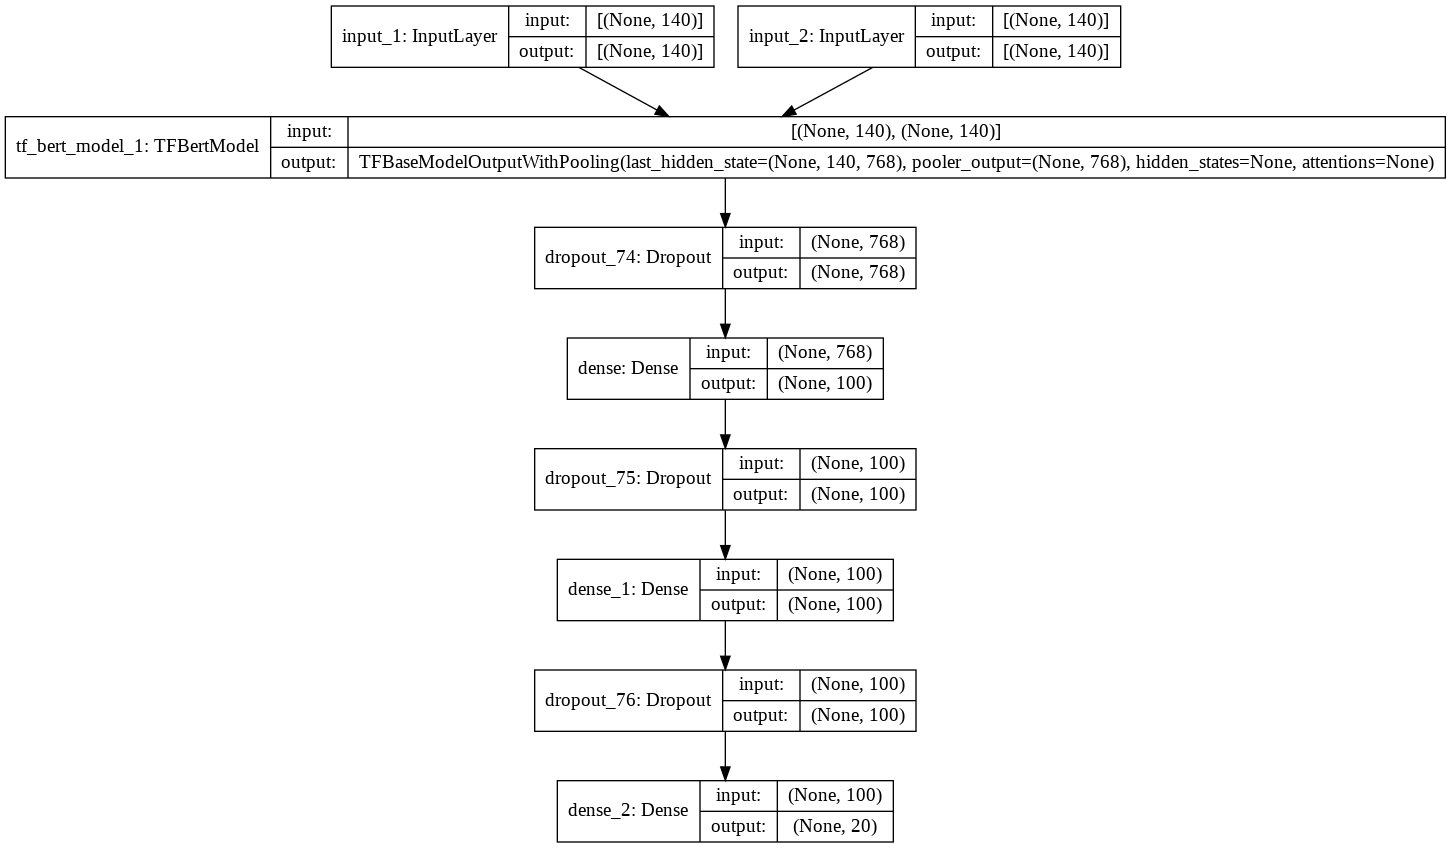

In [ ]:
plot_model(bertmodel, to_file='model.png', expand_nested=True, show_shapes=True)

In [ ]:
type(totalX)

list

In [ ]:
train_input_ids,train_attention_masks = bert_encode(totalX)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print(train_input_ids.shape)
print(train_attention_masks.shape)
print(totalY.shape)

(21578, 140)
(21578, 140)
(21578, 20)


## Fit Data In Model

In [ ]:
history = bertmodel.fit([train_input_ids,train_attention_masks],totalY,validation_split = 0.2 , epochs=4,batch_size=32)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/4


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


540/540 [==============================] - ETA: 0s - loss: 0.4939 - accuracy: 0.1901 - precision: 0.1309 - f1_m: 0.2118

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


540/540 [==============================] - 594s 1s/step - loss: 0.4937 - accuracy: 0.1904 - precision: 0.1310 - f1_m: 0.2120 - val_loss: 0.1118 - val_accuracy: 0.7331 - val_precision: 0.8539 - val_f1_m: 0.7609
Epoch 2/4
540/540 [==============================] - 591s 1s/step - loss: 0.2088 - accuracy: 0.5137 - precision: 0.4491 - f1_m: 0.5100 - val_loss: 0.0748 - val_accuracy: 0.8408 - val_precision: 0.8420 - val_f1_m: 0.7967
Epoch 3/4
540/540 [==============================] - 592s 1s/step - loss: 0.1327 - accuracy: 0.6045 - precision: 0.6520 - f1_m: 0.6654 - val_loss: 0.0742 - val_accuracy: 0.8239 - val_precision: 0.8437 - val_f1_m: 0.8105
Epoch 4/4
540/540 [==============================] - 595s 1s/step - loss: 0.0994 - accuracy: 0.6462 - precision: 0.7618 - f1_m: 0.7474 - val_loss: 0.0673 - val_accuracy: 0.8441 - val_precision: 0.8491 - val_f1_m: 0.8480


In [ ]:
history.history["loss"]

[0.3781179189682007,
 0.1842132955789566,
 0.12399621307849884,
 0.09587664902210236]


# DistilBert


# Import libray

In [ ]:
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# DistilBert-Tokenizer

In [ ]:
from transformers import DistilBertTokenizer
from keras.preprocessing.sequence import pad_sequences

distilbert_model_name = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(distilbert_model_name, do_lower_case=True, truncation=True)
MAX_LEN = 150

def tokenize_sentences(sentences, tokenizer, max_seq_len = 150):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,
                            truncation = True          # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

input_ids = tokenize_sentences(totalX, tokenizer, MAX_LEN)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
attention_masks = create_attention_masks(input_ids)


100%|██████████| 21578/21578 [00:46<00:00, 464.95it/s]


In [ ]:
type(totalY)

numpy.ndarray

# Split Data

In [ ]:
from sklearn.model_selection import train_test_split


train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, totalY, random_state=0, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, totalY, random_state=0, test_size=0.2)

train_size = len(train_inputs)
validation_size = len(validation_inputs)

In [ ]:
train_masks.shape

(17262, 150)

In [ ]:
BATCH_SIZE = 16
NR_EPOCHS = 4

# Model_build

In [ ]:
import tensorflow as tf
from transformers import TFDistilBertModel
from tensorflow.keras.layers import Dense, Flatten,Dropout

class DistilBertClassifier(tf.keras.Model):    
    def __init__(self, distilbert: TFDistilBertModel, num_classes: int):
        super().__init__()
        self.distilbert = distilbert
        self.classifier1=Dense(150, activation='relu')
        self.classifier2=Dense(100, activation='relu')
        self.classifier = Dense(num_classes, activation='sigmoid')
        
    @tf.function
    def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        outputs = self.distilbert.distilbert(input_ids,
                               attention_mask=attention_mask,
                               head_mask=head_mask)
        cls_output = outputs[0][:,0,:]
        cls_output=Dropout(.3)(cls_output)
        cls_output = self.classifier1(cls_output)
       
        # cls_output=Dropout(.1)(cls_output)
        # cls_output = self.classifier2(cls_output)
       
        cls_output=Dropout(.2)(cls_output)
        cls_output = self.classifier(cls_output)
                
        return cls_output

model = DistilBertClassifier(TFDistilBertModel.from_pretrained(distilbert_model_name), 20)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
from tensorflow.keras.optimizers import Adam

# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
train_auc_metrics = tf.keras.metrics.AUC()
train_precision_metrics = tf.keras.metrics.Precision()

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss_object, 
    metrics = ["accuracy", train_precision_metrics,f1_m])

In [ ]:
t_labels = tf.dtypes.cast(train_labels, tf.float32)
val_labels = tf.dtypes.cast(validation_labels, tf.float32)

# Fit the model

In [ ]:
model.fit((train_inputs, train_masks), t_labels, epochs=NR_EPOCHS, batch_size=BATCH_SIZE, steps_per_epoch=train_size//BATCH_SIZE, validation_data=((validation_inputs, validation_masks), val_labels))

Epoch 1/4
1078/1078 [==============================] - 342s 309ms/step - loss: 0.1416 - accuracy: 0.6310 - precision_3: 0.7534 - f1_m: 0.6574 - val_loss: 0.0659 - val_accuracy: 0.6840 - val_precision_3: 0.9009 - val_f1_m: 0.8419
Epoch 2/4
1078/1078 [==============================] - 332s 308ms/step - loss: 0.0599 - accuracy: 0.6866 - precision_3: 0.9049 - f1_m: 0.8621 - val_loss: 0.0570 - val_accuracy: 0.6636 - val_precision_3: 0.9014 - val_f1_m: 0.8689
Epoch 3/4
1078/1078 [==============================] - 332s 308ms/step - loss: 0.0526 - accuracy: 0.6853 - precision_3: 0.9115 - f1_m: 0.8806 - val_loss: 0.0547 - val_accuracy: 0.6446 - val_precision_3: 0.9110 - val_f1_m: 0.8754
Epoch 4/4
1078/1078 [==============================] - 332s 308ms/step - loss: 0.0476 - accuracy: 0.6782 - precision_3: 0.9224 - f1_m: 0.8942 - val_loss: 0.0533 - val_accuracy: 0.6946 - val_precision_3: 0.9157 - val_f1_m: 0.8781
